In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pathlib
import ast
import scipy.stats

In [2]:
from bci_plot.utils import data_util
from bci_plot.metadata import sessions_info_w_day
from bci_plot.gen_fig.adaptation import gen_adaptation_fig
from bci_plot.gen_data.adaptation import get_v

In [3]:
src_dir = pathlib.Path('../../data/adaptation')

In [4]:
stats = {}
for (session, decoder_name, fold, subject, subject_day) in sessions_info_w_day.sessions_info:
    if subject not in stats:
        stats[subject] = []
    # Assumes the metadata is already ordered!
    while len(stats[subject]) <= subject_day:
        stats[subject].append([])
    with open(src_dir / f'{session}.pickle', 'rb') as f:
        session_stats = pickle.load(f)
        session_stats['header'] = (session, decoder_name, fold, subject, subject_day)
        stats[subject][subject_day].append(session_stats)

In [5]:
def cat(x):
    if len(x) == 0:
        return np.zeros(0)
    return np.concatenate(x)

In [6]:
with open('../../data/adaptation/violin_info.pickle', 'rb') as f:
    violin_info = pickle.load(f)

compiled_stats = {subject: dict() for subject in stats}
for subject, subject_stats in stats.items():
    compiled_stats[subject]['day_bps'] = [cat([session_stats['block_bps'] for session_stats in day_stats]) for day_stats in subject_stats]
    compiled_stats[subject]['day_success'] = [cat([session_stats['block_success'] for session_stats in day_stats]) for day_stats in subject_stats]
    compiled_stats[subject]['day_ttt'] = [cat([session_stats['block_ttt'] for session_stats in day_stats]) for day_stats in subject_stats]
    compiled_stats[subject]['day_ftts'] = [0.050*cat([session_stats['block_ftts'] for session_stats in day_stats]) for day_stats in subject_stats]
    compiled_stats[subject]['day_is_eval'] = [cat([session_stats['block_is_eval'] for session_stats in day_stats]) for day_stats in subject_stats]
    compiled_stats[subject]['day_td'] = [cat([session_stats['block_td'] for session_stats in day_stats]) for day_stats in subject_stats]
    compiled_stats[subject]['decoder_name'] = [cat([[session_stats['header'][1]]*len(session_stats['block_bps']) for session_stats in day_stats]) for day_stats in subject_stats]
    compiled_stats[subject]['day_bps_ftt'] = [cat([session_stats['block_bps_ftt'] for session_stats in day_stats]) for day_stats in subject_stats]
    compiled_stats[subject]['day_bps_gilja'] = [cat([session_stats['block_bps_gilja'] for session_stats in day_stats]) for day_stats in subject_stats]
    if subject in sessions_info_w_day.omitted_days:
        compiled_stats[subject]['omitted_days'] = sessions_info_w_day.omitted_days[subject]
    compiled_stats[subject]['violin_info'] = violin_info[subject]

In [7]:
# bps with (hold, first touch) for each day
np.array([[d.mean() for d in compiled_stats[subject]['day_bps_ftt']] for subject in ['S2', 'H1', 'H2', 'H4']])

array([[0.16982989, 0.1710327 , 0.16163019, 0.18685715, 0.13864424],
       [0.29615054, 0.37452551, 0.38359206, 0.34778015, 0.39136533],
       [0.19707818, 0.20073681, 0.26801289, 0.28435659, 0.25691495],
       [0.24664822, 0.22301177, 0.20678028, 0.25061159, 0.30503501]])

In [8]:
# bps with (hold, first touch) for each day
np.array([[d.mean() for d in compiled_stats[subject]['day_bps_gilja']] for subject in ['S2', 'H1', 'H2', 'H4']])

array([[0.10121866, 0.11525149, 0.09941753, 0.13860251, 0.10359306],
       [0.19011368, 0.25307505, 0.2373848 , 0.24450567, 0.23521219],
       [0.13087353, 0.14170288, 0.18810704, 0.17693133, 0.18956709],
       [0.15770726, 0.16158048, 0.15062554, 0.17168961, 0.19296862]])

In [9]:
for subject, subject_stats in compiled_stats.items():
    statistics = [[scipy.stats.ranksums(day1, day2)[0] for day2 in subject_stats['day_bps_ftt']] for day1 in subject_stats['day_bps_ftt']]
    ps = [[scipy.stats.ranksums(day1, day2)[1] for day2 in subject_stats['day_bps_ftt']] for day1 in subject_stats['day_bps_ftt']]
    print(subject, ', n=',[len(item) for item in subject_stats['day_bps_ftt']], sep='')
    print('Fitts ftt; p=')
    print(np.array(ps).round(4))
    print('Fitts ftt; U=')
    print(np.array(statistics).round(4))
    
    esc = "\\,"
    for i in range(len(ps)):
        s_str = [(f'{statistics[i][j]:0.3f}' if i > j else esc) for j in range(len(ps))]
        p_str = [
            (        f'\\textit{{{ps[i][j]:0.3f}}}' if i > j else esc) if ps[i][j] >= 0.005 else \
            (        f'\\textbf{{\\textit{{{ps[i][j]:0.3f}}}}}' if i > j else esc) \
            for j in range(len(ps))
        ]
        
        print(f'{i+1} ' + ''.join([f'& {s_str[j]} & {p_str[j]}'  for j in range(len(ps)-1)]) + ' \\cr')

H1, n=[14, 23, 19, 20, 10]
Fitts ftt; p=
[[1.     0.0241 0.0056 0.0864 0.0303]
 [0.0241 1.     0.7713 0.5109 0.6665]
 [0.0056 0.7713 1.     0.238  0.7136]
 [0.0864 0.5109 0.238  1.     0.291 ]
 [0.0303 0.6665 0.7136 0.291  1.    ]]
Fitts ftt; U=
[[ 0.     -2.2548 -2.7684 -1.7146 -2.1665]
 [ 2.2548  0.     -0.2906  0.6574 -0.4309]
 [ 2.7684  0.2906  0.      1.1801 -0.3671]
 [ 1.7146 -0.6574 -1.1801  0.     -1.0559]
 [ 2.1665  0.4309  0.3671  1.0559  0.    ]]
1 & \, & \,& \, & \,& \, & \,& \, & \, \cr
2 & 2.255 & \textit{0.024}& \, & \,& \, & \,& \, & \, \cr
3 & 2.768 & \textit{0.006}& 0.291 & \textit{0.771}& \, & \,& \, & \, \cr
4 & 1.715 & \textit{0.086}& -0.657 & \textit{0.511}& -1.180 & \textit{0.238}& \, & \, \cr
5 & 2.166 & \textit{0.030}& 0.431 & \textit{0.667}& 0.367 & \textit{0.714}& 1.056 & \textit{0.291} \cr
H2, n=[10, 15, 17, 16, 9]
Fitts ftt; p=
[[1.     0.7393 0.0036 0.0098 0.0412]
 [0.7393 1.     0.0012 0.0044 0.0295]
 [0.0036 0.0012 1.     0.614  0.9356]
 [0.0098 0.0044 0

In [10]:
plotter_input = [
    {subject: compiled_stats[subject] for subject in sorted([s for s in stats if s[0] == 'S'])},
    {subject: compiled_stats[subject] for subject in sorted([s for s in stats if s[0] == 'H'])},
]

time to target median ['S2', 'H1', 'H2', 'H4'] [10.131250000000001, 6.987500000000001, 9.33125, 9.55625]


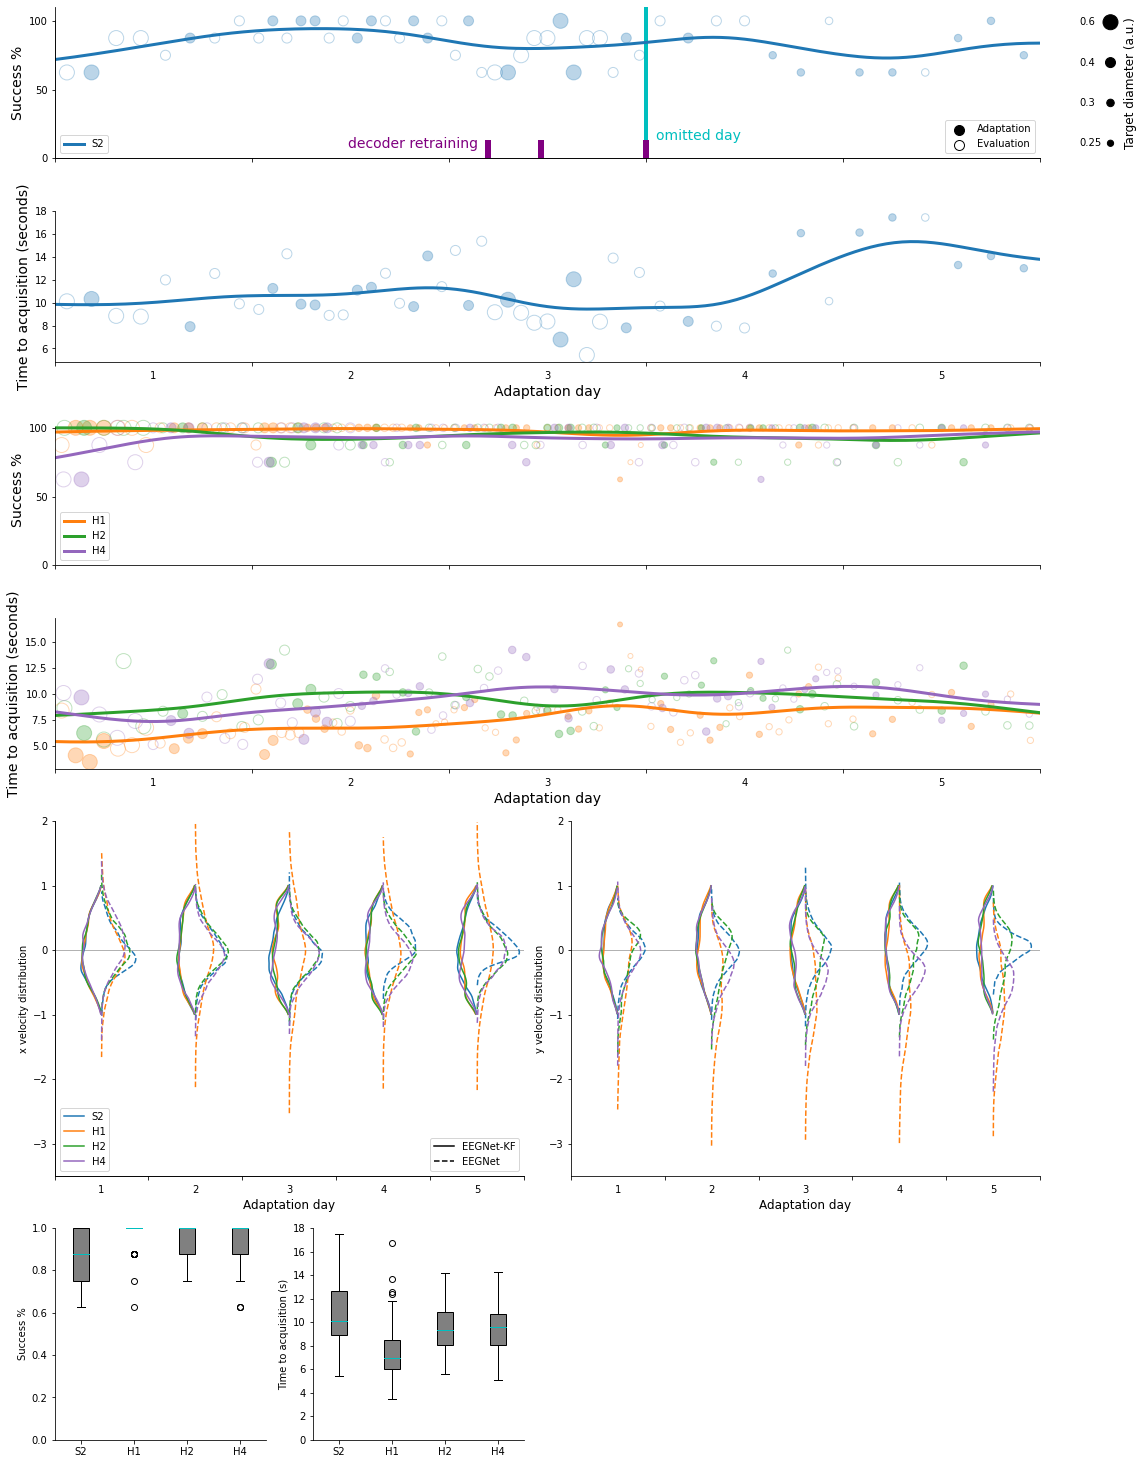

In [11]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig = gen_adaptation_fig.gen_adaptation_fig(plotter_input, smooth_std=0.3)
plt.savefig('../../figs/adaptation/adaptation_fig.pdf')

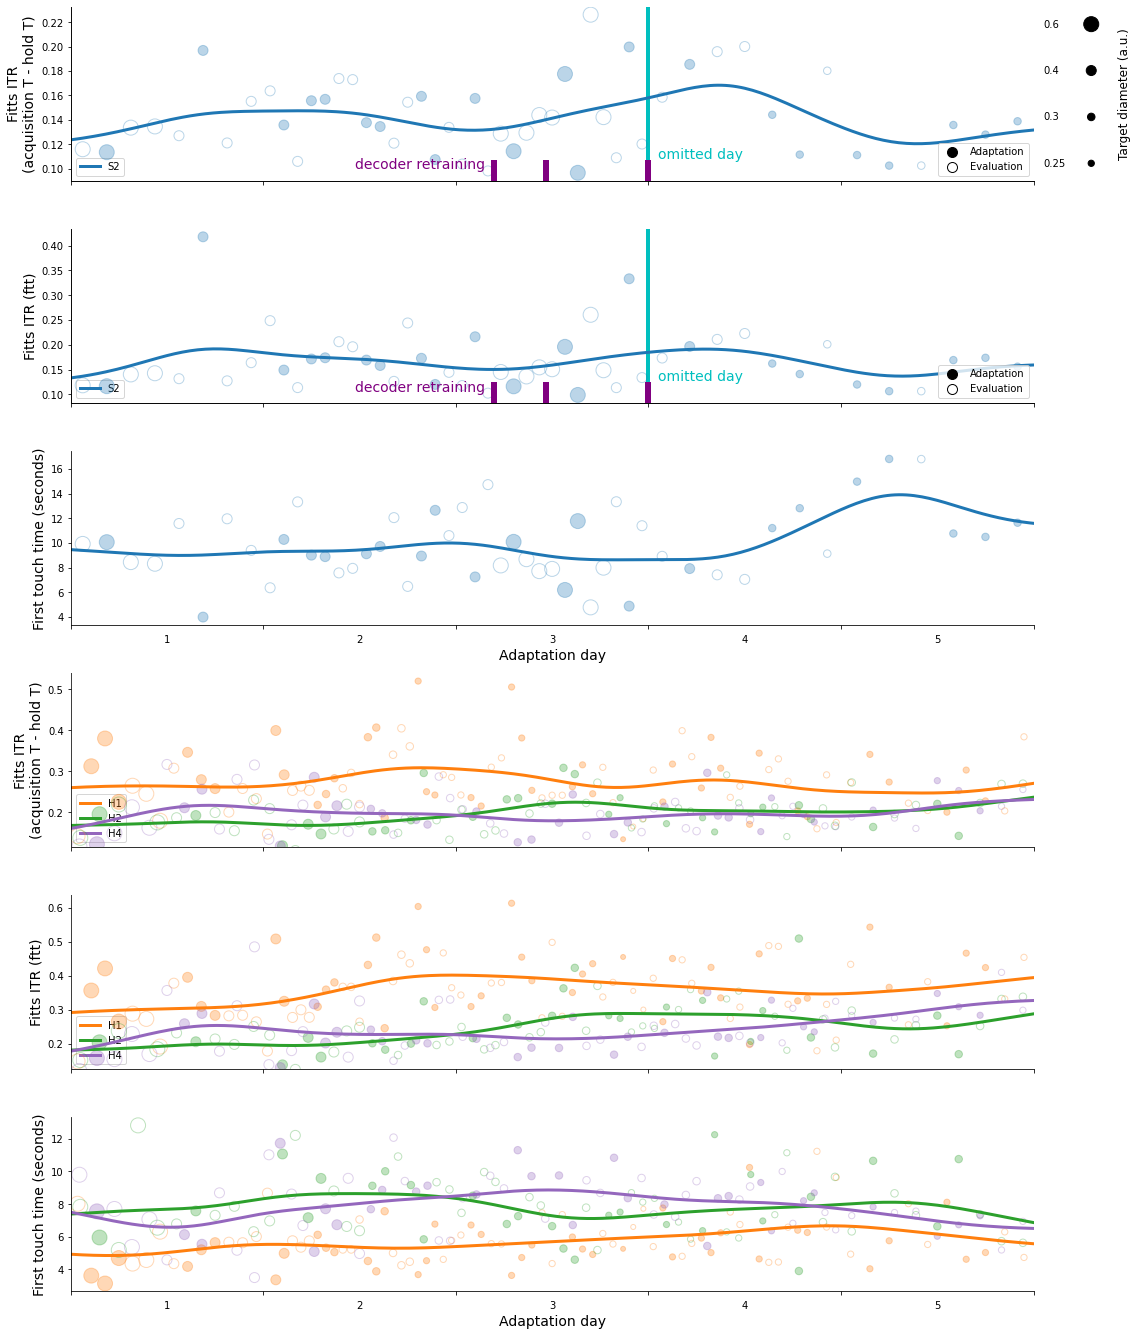

In [12]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig = gen_adaptation_fig.gen_adaptation_supp_fig(plotter_input, smooth_std=0.3)
plt.savefig('../../figs/adaptation/adaptation_supp_fig.pdf')